This notebook shows a version of possible exploration that can be done of the dataframes generated in the 'GeneratingCSVs.ipynb' notebook. The code written here was used to generate all figures in the 'An Investigation of Trust in Automated Performance Reviews from Various Professional Perspectives' research paper, unless otherwise stated. Note that this is the way to replicate the investigation, but feel free to investigate other methods to obtain insights from the data by using the functions.

In [2]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from numpy.linalg import cond
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Generate a random seed to ensure reproducibility of results
np.random.seed(42)
# Read the files generated in 'GenereatingCSVs.ipynb' and prepare the data and metadata dataframes. Replace the path for the path
# of your dataframes
red_path = 'reduced.csv'
loc_path = 'Locations.csv'
meta_path = 'metadata.csv'


"""
red (pd.DataFrame): The DataFrame containing the main data.
meta (pd.Dataframe): The Dataframe containing additional information on participants and their conditions.
loc (pd.Dataframe): The Dataframe containing
"""
red = pd.read_csv(red_path)
meta = pd.read_csv(meta_path)
loc = pd.read_csv(loc_path)

In [4]:
# Functions to be used throughout this notebook can be found here.
def fill_yes_no(df, columns):
    """
    Fill NaN values in specified columns with random 'Yes' or 'No' strings.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    columns (list): A list of column names to fill with 'Yes' or 'No'.
    """
    for column in columns:
        # Generate random choices for NaN positions
        random_choices = np.random.choice(['Yes', 'No'], size=df[column].isna().sum())
        df.loc[df[column].isna(), column] = random_choices

def classify_quadrant(row, stat1, stat2, m1, m2):
    """
    Generate quadrant classifications. Quadrant 1 is top right. Quadrant 2 is top left. Quadrant 3 is bottom left.
    Quadrant 4 is bottom right.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    columns (list): A list of column names to fill with 'Yes' or 'No'.
    """
    if row[stat1] > m1 and row[stat2] > m2:
        return 1
    elif row[stat1] <= m1 and row[stat2] > m2:
        return 2
    elif row[stat1] <= m1 and row[stat2] <= m2:
        return 3
    elif row[stat1] > m1 and row[stat2] <= m2:
        return 4
    
    
def quadrant_stats(dataframe, quadrant_column, relevant_column):
    """
    Generate statistics on the population of each quadrant, depending on the relevant column chosen.
    
    Parameters:
    dataframe (pd.DataFrame): The DataFrame containing the data.
    quadrant_column: The column containing the quadrant the participant belongs to.
    relevant_column: The column with the data for which statistics want to be known (Must be a yes or
    no question enconded to 1 and 0)
    """
    print('Participants per quadrant')
    print(dataframe[quadrant_column].value_counts())
    print(f'Participants who responded yes to {relevant_column}')
    print(dataframe[quadrant_column][dataframe[relevant_column]==1].value_counts())
    print(f'Participants who responded no to {relevant_column}')
    print(dataframe[quadrant_column][dataframe[relevant_column]==0].value_counts())
    print(f'Participants by response to {relevant_column} in quadrant 4')
    print(dataframe[relevant_column][dataframe[quadrant_column]==4].value_counts())
    print(f'Participants by response to {relevant_column} in quadrant 3')
    print(dataframe[relevant_column][dataframe[quadrant_column]==3].value_counts())
    print(f'Participants by response to {relevant_column} in quadrant 2')
    print(dataframe[relevant_column][dataframe[quadrant_column]==2].value_counts())
    print(f'Participants by response to {relevant_column} in quadrant 1')
    print(dataframe[relevant_column][dataframe[quadrant_column]==1].value_counts())
    print(f'Percentage of participants who responded yes to {relevant_column} in total')
    print(len(dataframe[dataframe[relevant_column]==1])/len(dataframe))
    print(f'Percentage of participants who responded yes to {relevant_column} in quadrant 1')
    print(len(dataframe[dataframe[quadrant_column]==1][dataframe[relevant_column]==1])/len(dataframe[dataframe[quadrant_column]==1]))
    print(f'Percentage of participants who responded yes to {relevant_column} in quadrant 2')
    print(len(dataframe[dataframe[quadrant_column]==2][dataframe[relevant_column]==1])/len(dataframe[dataframe[quadrant_column]==2]))
    print(f'Percentage of participants who responded yes to {relevant_column} in quadrant 3')
    print(len(dataframe[dataframe[quadrant_column]==3][dataframe[relevant_column]==1])/len(dataframe[dataframe[quadrant_column]==3]))
    print(f'Percentage of participants who responded yes to {relevant_column} in quadrant 4')
    print(len(dataframe[dataframe[quadrant_column]==4][dataframe[relevant_column]==1])/len(dataframe[dataframe[quadrant_column]==4]))
    
    
def shapiro_test(df, column):
    """
    Perform a Shapiro Normality test and print the result.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column (string): A column name for the column with the data to check for normality.
    """
    # normality test
    stat, p = shapiro(df[column])
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret results
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')
        

def anova_test(df, independent_var, dependent_var):
    """
    Perform an analysis of variance test and print the result.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    independent_var (string): A column name for the column with the independent variable.
    dependent_var (string): A column name for the column with the dependent variable.
    """
    
    # Group the dependent variable by the independent variable
    groups = [group[dependent_var].values for name, group in df.groupby(independent_var)]
    
    # Perform the ANOVA test
    f_stat, p_value = f_oneway(*groups)
    
   
    
    # Determine if the variables are related based on the p-value
    if p_value < 0.05:
         # Print the results
        print(f"ANOVA results for {independent_var} affecting {dependent_var}:")
        print(f"F-statistic: {f_stat:.4f}")
        print(f"P-value: {p_value:.4f}")
        print("The variables are statistically related (reject the null hypothesis).")      
     
    
def multinomial_logistic_regression(df, dependent_var, independent_vars):
    """
    Perform a Multinomial Logistic Regression to check if the independent variables affect the categorical dependent variable.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    dependent_var (str): The name of the dependent variable (categorical).
    independent_vars (list): A list of names of the independent variables.
    """
    
    # Create the formula for the logistic regression
    formula = f"{dependent_var} ~ " + " + ".join(independent_vars)
    
    # Fit the multinomial logistic regression model
    model = smf.mnlogit(formula, data=df)
    result = model.fit()
    
    # Print the summary of the model, which includes coefficients and p-values
    print(result.summary())
    
def correlation_matrix(df, name, dependent_var, independent_vars, method='pearson'):
    """
    Generate and display a correlation matrix for the specified dependent and independent variables.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    dependent_var (str): The name of the dependent variable.
    independent_vars (list): A list of names of the independent variables.
    method (str): The method of correlation ('pearson', 'spearman', 'kendall'). Default is 'pearson'.
    """
    
    # Create a list of variables to include in the correlation matrix
    variables = [dependent_var] + independent_vars
    
    # Compute the correlation matrix
    corr_matrix = df[variables].corr(method=method)
    
    # Plot the heatmap for the correlation matrix
    plt.figure(figsize=(15, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=1, linecolor='black')
    
    # Save the plot
    plt.savefig(f'{method.capitalize()}CorrelationMatrix{name}.png', bbox_inches = 'tight')
    
    # Show the plot
    plt.show()

    
def scatter_plot_quadrants(df, x_val, y_val, legend, legend_title, name, x_label, y_label):
    """
    Generate and display a scatterplot with quadrants and a line of best fit, as well as a legend.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    x_val (str): The name of the x-axis variable.
    y_val (str): The name of the y-axis variable.
    legend (str): The name of the variable to use for colour-coding.
    legend_title (str): The title of the legend
    name (str): The name of the png file to be generated to save the graph.
    x_label (str): The label for the x axis.
    y_label (str): The label for the y axis.
    """
    sns.set(style="whitegrid")

    # Calculate the counts for each class in the legend
    class_counts = df[legend].value_counts().to_dict()

    # Create a custom label list for the legend
    legend_labels = [f'{label} (n={class_counts[label]})' for label in class_counts]

    plt.figure(figsize=(10, 6))
    scatter_plot = sns.scatterplot(
        data=df, 
        x=x_val, 
        y=y_val, 
        hue=legend, 
        palette='Set1', 
        s=100
    )

    # Add the line of best fit
    sns.regplot(
        data=df, 
        x=x_val, 
        y=y_val, 
        scatter=False, 
        color='black', 
        line_kws={"linestyle":"--"}
    )

    # Add the mean lines
    plt.axhline(y=df[y_val].mean(), color='gray', linestyle='--')
    plt.axvline(x=df[x_val].mean(), color='gray', linestyle='--')

    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Fit the linear regression model
    X = df[x_val].values.reshape(-1, 1)
    y = df[y_val].values
    model = LinearRegression().fit(X, y)
    r_squared = model.score(X, y)
    slope = model.coef_[0]
    intercept = model.intercept_

    # Annotate the R² value on the top-right corner
    plt.text(
        x=1.01, 
        y=0.99, 
        s=f'$R^2$ = {r_squared:.2f}', 
        transform=plt.gca().transAxes, 
        fontsize=12, 
        rotation=-90,  
        verticalalignment='top', 
        horizontalalignment='left',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.8)
    )

    # Annotate the line equation on the right
    line_eq = f'$y = {slope:.2f}x + {intercept:.2f}$'
    plt.text(
        x=1.01, 
        y=0.35, 
        s=line_eq, 
        transform=plt.gca().transAxes, 
        fontsize=12, 
        rotation=-90,
        verticalalignment='top', 
        horizontalalignment='left',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.8)
    )

    # Update legend labels with the counts
    handles, labels = scatter_plot.get_legend_handles_labels()

    # Mapping from original class labels to the custom labels with counts
    label_map = {label: f'{label} (n={class_counts[label]})' for label in labels}
    ordered_labels = [label_map[label] for label in df[legend].unique()]
    ordered_handles = [handles[labels.index(label)] for label in df[legend].unique()]

    scatter_plot.legend(
        handles=ordered_handles, 
        labels=ordered_labels, 
        title=legend_title, 
        bbox_to_anchor=(1.05, 1), 
        loc='upper left'
    )

    plt.subplots_adjust(right=0.7, bottom=0.1)
    plt.savefig(f'{name}.png')
    plt.show()

def scatter_for_PCA(df, x_val, y_val, legend, legend_title, name, x_label, y_label):
    """
    Generate and display a scatterplot for PCA including a legend.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    x_val (str): The name of the x-axis variable.
    y_val (str): The name of the y-axis variable.
    legend (str): The name of the variable to use for colour-coding.
    legend_title (str): The title of the legend
    name (str): The name of the png file to be generated to save the graph.
    x_label (str): The label for the x axis.
    y_label (str): The label for the y axis.
    """
    sns.set(style="whitegrid")

    # Calculate the counts for each class in the legend
    class_counts = df[legend].value_counts().to_dict()

    # Create a custom label list for the legend
    legend_labels = [f'{label} (n={class_counts[label]})' for label in class_counts]
    print(legend_labels)
    plt.figure(figsize=(10, 6))
    scatter_plot = sns.scatterplot(
        data=df, 
        x=x_val, 
        y=y_val, 
        hue=legend, 
        palette='Set1', 
        s=100
    )

    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Update legend labels with the counts
    handles, labels = scatter_plot.get_legend_handles_labels()

    # Mapping from original class labels to the custom labels with counts
    label_map = {label: f'{label} (n={class_counts[label]})' for label in labels}
    ordered_labels = [label_map[label] for label in df[legend].unique()]
    ordered_handles = [handles[labels.index(label)] for label in df[legend].unique()]

    scatter_plot.legend(
        handles=ordered_handles, 
        labels=ordered_labels, 
        title=legend_title, 
        bbox_to_anchor=(1.05, 1), 
        loc='upper left'
    )

    plt.subplots_adjust(right=0.7, bottom=0.1)
    plt.savefig(f'{name}.png')
    plt.show()    

def describe_and_visualize(df, column):
    """
    Generate descriptive statistics and visualizations for a specific column.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column (string): The column name for which to generate descriptive statistics and visualizations.
    """
    # Generate descriptive statistics
    description = df[column].describe()
    print(f'Descriptive statistics for {column}:\n', description)
    
    # Set up the matplotlib figure
    plt.figure(figsize=(12, 5))
    
    # Plot a histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[column], kde=True, color='skyblue')
    plt.title(f'Histogram of {column} frequencies')
    plt.xlabel(f'{column} value')
    plt.ylabel('Frequency')
    
    # Plot a boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[column], color='lightgreen')
    plt.title(f'Boxplot of {column}')
    
    # Show the plots
    plt.tight_layout()
    plt.show()

def calculate_vif(df):
    """
    Calculate Variance Inflation Factor (VIF) for each feature in the DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the features (independent variables).
    
    Returns:
    pd.DataFrame: A DataFrame with features and their corresponding VIF values.
    """
    
    # Adding a constant column for VIF calculation
    df = df.copy()  # Create a copy to avoid altering the original DataFrame
    df['intercept'] = 1  # Add intercept to handle the constant in the VIF calculation
    
    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data['Feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    
    # Drop the intercept row from the result
    vif_data = vif_data[vif_data['Feature'] != 'intercept']
    
    vif_data.to_csv('vif.csv', index=False)
    return vif_data


def plot_sina(df, columns):
    """
    Creates a sina plot for specified columns in a dataframe.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    columns (list): List of column titles to include in the plot.
    """
    # Validate the columns
    for col in columns:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' does not exist in the dataframe.")

    # Melt the dataframe for seaborn
    df_melted = df[columns].melt(var_name='Variables', value_name='Values')

    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Variables', y='Values', data=df_melted, inner=None, color='skyblue')

    # Add points on top of the violin plot
    sns.stripplot(x='Variables', y='Values', data=df_melted, dodge=True, alpha=0.5, color='black')

    # Rotate the x-axis labels
    plt.xticks(rotation=75)

    # Set axis labels and title
    plt.ylabel('Agreement with statement (0=Disagree, 7=Agree)')

    # Save the plot to a file
    plot_filename = f'sina{df.shape[0]}.png'
    plt.savefig(plot_filename, bbox_inches='tight')

    # Show the plot
    plt.show()

def perform_pca(df, n_components):
    """
    Perform PCA on the dataset and return the explained variance and the dataset with added principal components.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the data (only numeric columns).
    n_components (int): The number of principal components to compute.

    Returns:
    pd.DataFrame: The original DataFrame with the first two principal components added as 'PC1' and 'PC2'.
    """
    # Ensure only numeric data is used for PCA
    numeric_df = df.select_dtypes(include=[float, int])

    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numeric_df)

    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_results = pca.fit_transform(scaled_data)
    print(pca.explained_variance_ratio_)
    # Explained variance by each principal component
    explained_variance = pca.explained_variance_ratio_
    for i, var in enumerate(explained_variance, start=1):
        print(f'Explained Variance for PC{i}: {var:.4f}')

    # Add the first two principal components to the original dataset
    df['PC1'] = pca_results[:, 0]
    df['PC2'] = pca_results[:, 1] if n_components > 1 else 0  # Add PC2 only if n_components > 1

    return df

def perform_hierarchical_clustering(df, n_clusters):
    """
    Perform hierarchical clustering on the dataset and plot a dendrogram.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data (only numeric columns).
    n_clusters (int): The number of clusters to form.

    Returns:
    pd.Series: A series with cluster labels assigned to each observation in the dataset.
    """
    # Ensure only numeric data is used for clustering
    numeric_df = df.select_dtypes(include=[float, int])

    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numeric_df)

    # Perform hierarchical/agglomerative clustering
    clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
    cluster_labels = clustering.fit_predict(scaled_data)

    # Plot the dendrogram for visualization
    linked = linkage(scaled_data, method='ward')
    
    plt.figure(figsize=(10, 7))
    dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
    plt.savefig('Dendogram.png')
    plt.show()

    # Add cluster labels to the original dataset
    df['Cluster'] = cluster_labels

    return df['Cluster']


def plot_radar_chart(x0, x1, x2, columns, name, namex0, namex1, namex2):
    """
    Generate a radar plot to compare mean values across three datasets.
    
    Parameters:
    x0, x1, x2 (pd.DataFrame): The DataFrames to compare.
    columns (list): List of column names to compare.
    name (str): Name to be used for saving the plot.
    namex0, namex1, namex2 (str): The names for each of the dataframes
    """
    # Calculate mean for each dataset
    means_x0 = x0[columns].mean().values
    means_x1 = x1[columns].mean().values
    means_x2 = x2[columns].mean().values
    
    # Number of variables we're plotting
    num_vars = len(columns)
    
    # Compute angle for each axis
    angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
    angles += angles[:1]  # Complete the loop
    
    # Initialize radar plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    # Draw one axis per variable and add labels
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    
    plt.xticks(angles[:-1], columns, fontsize=13)
    
    # Draw y-labels
    ax.set_rlabel_position(0)
    plt.yticks([1, 3, 5, 7], ["1", "3", "5", "7"], color="grey", size=10)
    plt.ylim(0, 7)
    
    # Plot data for each dataset
    def add_to_plot(values, label, color):
        values = np.append(values, values[0])  # Repeat the first value to close the loop
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=label, color=color)
        ax.fill(angles, values, color, alpha=0.25)
    
    # Add each dataset to the plot with the count in the legend
    add_to_plot(means_x0, f'{namex0}: n={len(x0)}', 'blue')
    add_to_plot(means_x1, f'{namex1}: n={len(x1)}', 'green')
    add_to_plot(means_x2, f'{namex2}: n={len(x2)}', 'red')
    
    # Add a legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    # Save the plot
    plt.savefig(f'radarfor{name}.png', dpi=300, bbox_inches='tight')
    plt.close()

def plot_radar_chart_normalized(x0, x1, x2, columns, name, namex0, namex1, namex2):
    """
    Generate a radar plot to compare mean values across three datasets after normalizing the variables.
    
    Parameters:
    x0, x1, x2 (pd.DataFrame): The DataFrames to compare.
    columns (list): List of column names to compare.
    name (str): Name to be used for saving the plot.
    namex0, namex1, namex2 (str): The names for each of the dataframes.
    """
    # Normalize the data using Min-Max scaling
    scaler = MinMaxScaler()
    x0_norm = pd.DataFrame(scaler.fit_transform(x0[columns]), columns=columns)
    x1_norm = pd.DataFrame(scaler.fit_transform(x1[columns]), columns=columns)
    x2_norm = pd.DataFrame(scaler.fit_transform(x2[columns]), columns=columns)
    
    # Calculate mean for each dataset
    means_x0 = x0_norm.mean().values
    means_x1 = x1_norm.mean().values
    means_x2 = x2_norm.mean().values
    
    # Number of variables we're plotting
    num_vars = len(columns)
    
    # Compute angle for each axis
    angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
    angles += angles[:1]  # Complete the loop
    
    # Initialize radar plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    # Draw one axis per variable and add labels
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    
    plt.xticks(angles[:-1], columns, fontsize=13)
    
    # Draw y-labels
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=10)
    plt.ylim(0, 1)
    
    # Plot data for each dataset
    def add_to_plot(values, label, color):
        values = np.append(values, values[0])  # Repeat the first value to close the loop
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=label, color=color)
        ax.fill(angles, values, color, alpha=0.25)
    
    # Add each dataset to the plot with the count in the legend
    add_to_plot(means_x0, f'{namex0}: n={len(x0)}', 'blue')
    add_to_plot(means_x1, f'{namex1}: n={len(x1)}', 'green')
    add_to_plot(means_x2, f'{namex2}: n={len(x2)}', 'red')
    
    # Add a legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    # Save the plot
    plt.savefig(f'radarfor{name}.png', dpi=300, bbox_inches='tight')
    plt.close()

In [5]:
red.head()

,ProfessionType,Profession,Age,Deceptiveness,Underhandedness,SuspiciousIntent,Wariness,Harmful,Confident,Secure,...,Trust,Experience,Preference,Rating,Changes,Feedback,ResponseId,Negative,Positive,Country
0,Artistic,Illustrator,24.0,4.0,3.0,7.0,4.0,6.0,1.0,0.0,...,0.0,No,Yes,2.0,Yes,Questions are too long and some have similar m...,R_2SpZoRhK5EGXLEt,4.8,0.75,United Kingdom
1,Social,Law,26.0,1.0,6.0,1.0,1.0,2.0,5.0,4.0,...,5.0,Yes,No,4.0,Yes,The time. Taking fast decisions without time t...,R_3Gy9CI9sR2PqJqX,2.2,4.00,Colombia
2,Scientific,Psychiatry,26.0,2.0,2.0,1.0,3.0,1.0,5.0,3.0,...,7.0,No,No,5.0,No,NaN,R_23dnbHulLYSEWIx,1.8,4.25,Colombia
3,Scientific,Computer science,61.0,5.0,7.0,2.0,6.0,2.0,7.0,6.0,...,6.0,Yes,Yes,5.0,Yes,The age: a range would be better,R_2Jme5qHflT25lej,4.4,6.00,Colombia
4,Scientific,Chemical Engineering,24.0,2.0,2.0,2.0,3.0,2.0,5.0,5.0,...,3.0,Yes,No,5.0,No,NaN,R_1VMSbpDVdd2kHpT,2.2,4.00,Colombia


In [6]:
# Drop unusual values (All sevens or all zeroes)
conditions_to_drop = (
    ((red['Negative'] == 0) & (red['Positive'] == 0)) |
    ((red['Negative'] == 7) & (red['Positive'] == 7))
)
# Generate a copy of red to return in case of issues (Redturn)
redturn =red.copy()
# Remove outliers
red = red[~conditions_to_drop]

In [7]:
# Handle null values for columns that should not have them. Note that columns with data on feedback and location are not crucial
# and can be left blank
red['Age'] = red['Age'].fillna(red['Age'].mean())
fill_yes_no(red, ['Experience', 'Preference'])
red.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230 entries, 0 to 231
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ProfessionType    230 non-null    object 
 1   Profession        230 non-null    object 
 2   Age               230 non-null    float64
 3   Deceptiveness     230 non-null    float64
 4   Underhandedness   230 non-null    float64
 5   SuspiciousIntent  230 non-null    float64
 6   Wariness          230 non-null    float64
 7   Harmful           230 non-null    float64
 8   Confident         230 non-null    float64
 9   Secure            230 non-null    float64
 10  Integrity         230 non-null    float64
 11  Dependable        230 non-null    float64
 12  Familiarity       230 non-null    float64
 13  Trust             230 non-null    float64
 14  Experience        230 non-null    object 
 15  Preference        230 non-null    object 
 16  Rating            227 non-null    float64
 17  Ch

In [8]:
# Calculate mean positive and mean negative sentiment for red
mean_positive = red['Positive'].mean()
mean_negative = red['Negative'].mean()

# Generate the SentimentLevelQuadrant column, showing qualitative information on sentiment level
red['SentimentLevelQuadrant'] = red.apply(lambda row: classify_quadrant(row, 'Positive', 'Negative', mean_positive, mean_negative), axis=1)

# Generate mapping dictionaries
q1_mapping = {
    'Artistic': 1,
    'Social': 2,
    'Scientific': 3
}
q1_mapping_alternative = {
    'Scientific': 1,
    'Artistic': 2,
    'Social': 3
}
yes_no_mapping = {
    'Yes': 1,
    'No': 0
}
# Create the numeric columns to map important categorical columns to 
red['NumPT'] = red['ProfessionType'].map(q1_mapping)
red['NumExp'] = red['Experience'].map(yes_no_mapping)
red['NumPref'] = red['Preference'].map(yes_no_mapping)
red['AltPT'] = red['ProfessionType'].map(q1_mapping_alternative)


In [9]:
# Separate columns for different purposes throughout

# numeric_cols has all numerical columns
numeric_cols = ['Age', "Deceptiveness","Underhandedness", "SuspiciousIntent", "Wariness", "Harmful", "Confident", "Secure", "Integrity",
                "Dependable", "Familiarity", 'Trust', "Rating", "Negative", "Positive", "SentimentLevelQuadrant", "NumPT", "NumExp", "NumPref"]
# main_questions has all questions that are part of the original main section of the questionnaire
main_questions = ["Deceptiveness","Underhandedness", "SuspiciousIntent", "Wariness", "Harmful", "Confident", "Secure", "Integrity",
                "Dependable", "Familiarity", 'Trust']
# for_pca includes numeric variables specifically for a primary component analysis
for_pca = ['Age', "Deceptiveness","Underhandedness", "SuspiciousIntent", "Wariness", "Harmful", "Confident", "Secure", "Integrity",
                "Dependable", "Familiarity", 'Trust', "Negative", "Positive", "SentimentLevelQuadrant", "NumPT", "NumExp", "NumPref"]
# A simplified version of the dataset, curated using VIF values for multinomial logistic regression
simple_columns = ['Age', 'Wariness', 'SuspiciousIntent', 'Harmful','Deceptiveness', 'Secure', 'Trust', 'Familiarity', 'Positive', 'SentimentLevelQuadrant', 'NumPT', 'NumExp', 'NumPref']
# A different simplified version of the dataset, curated using VIF values for multinomial logistic regression for the second possible grouping
simple2 = ['Age', 'Wariness', 'SuspiciousIntent', 'Harmful','Deceptiveness', 'Secure', 'Trust', 'Familiarity', 'Positive', 'SentimentLevelQuadrant', 'AltPT', 'NumExp', 'NumPref']


Descriptive statistics for Age:
 count    230.000000
mean      28.628821
std       14.549336
min       18.000000
25%       19.000000
50%       22.000000
75%       30.000000
max       67.000000
Name: Age, dtype: float64


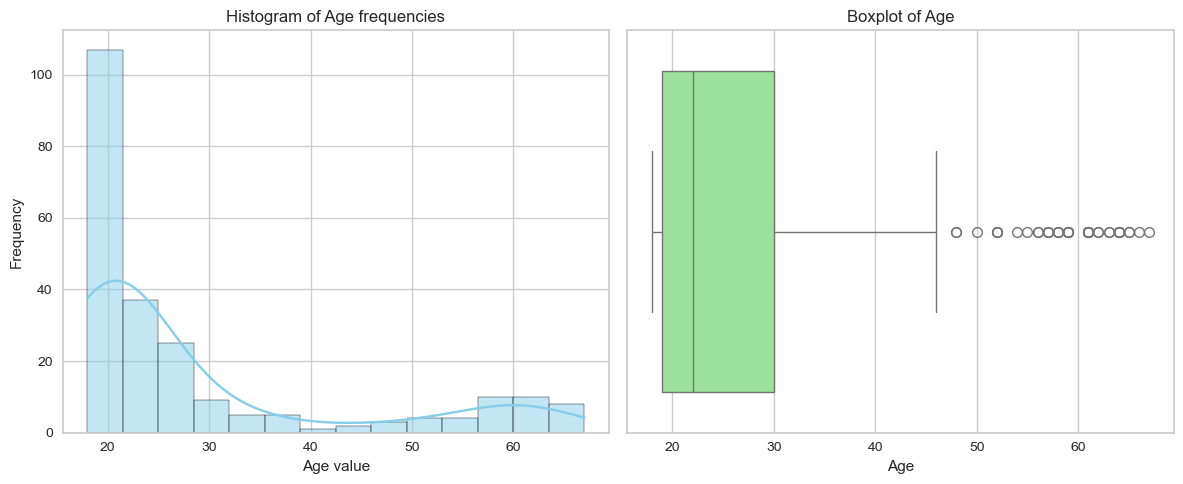

Descriptive statistics for Deceptiveness:
 count    230.000000
mean       3.334783
std        1.909779
min        0.000000
25%        2.000000
50%        4.000000
75%        5.000000
max        7.000000
Name: Deceptiveness, dtype: float64


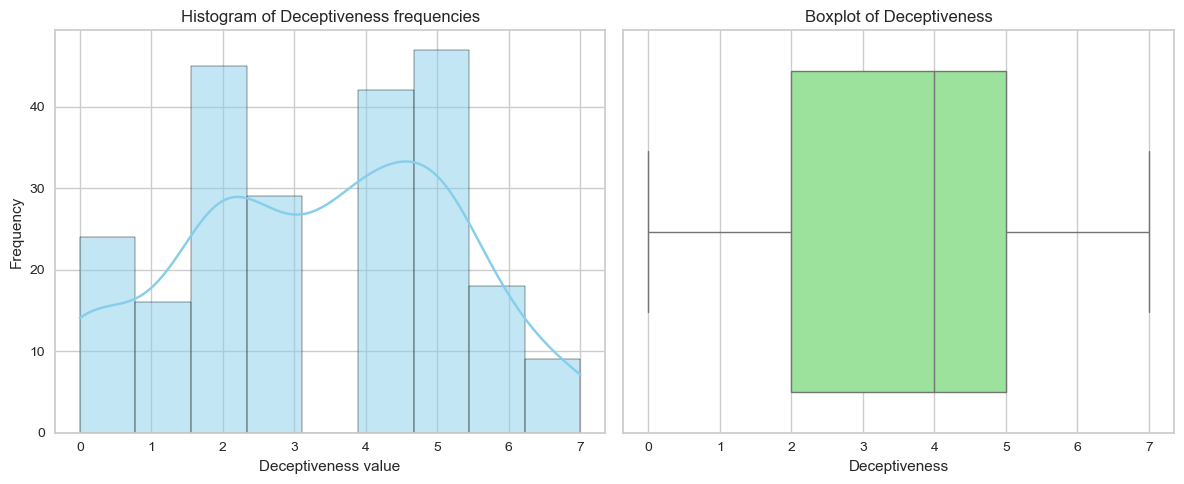

Descriptive statistics for Underhandedness:
 count    230.000000
mean       3.243478
std        2.026425
min        0.000000
25%        2.000000
50%        3.000000
75%        5.000000
max        7.000000
Name: Underhandedness, dtype: float64


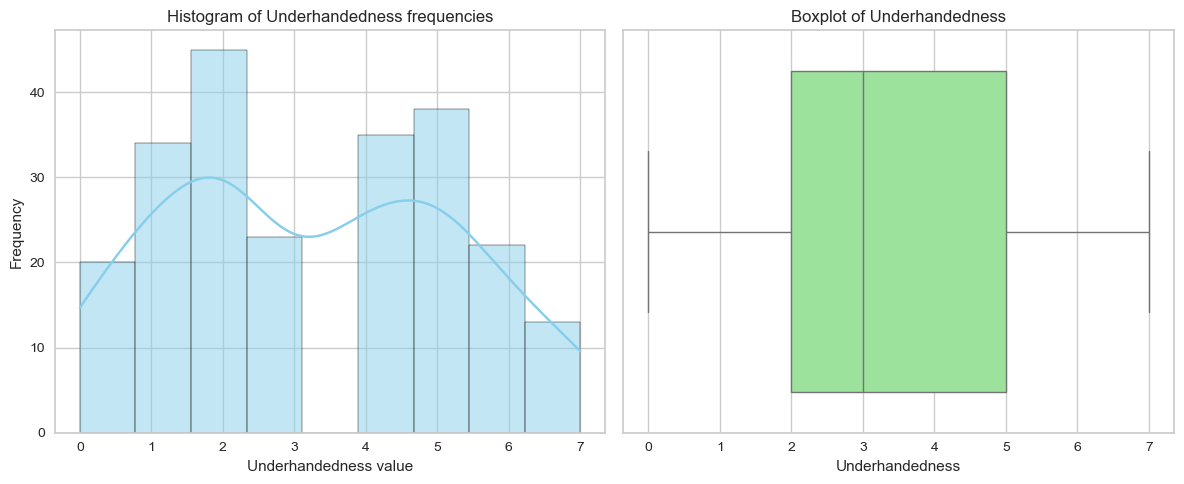

Descriptive statistics for SuspiciousIntent:
 count    230.000000
mean       3.456522
std        1.981426
min        0.000000
25%        2.000000
50%        4.000000
75%        5.000000
max        7.000000
Name: SuspiciousIntent, dtype: float64


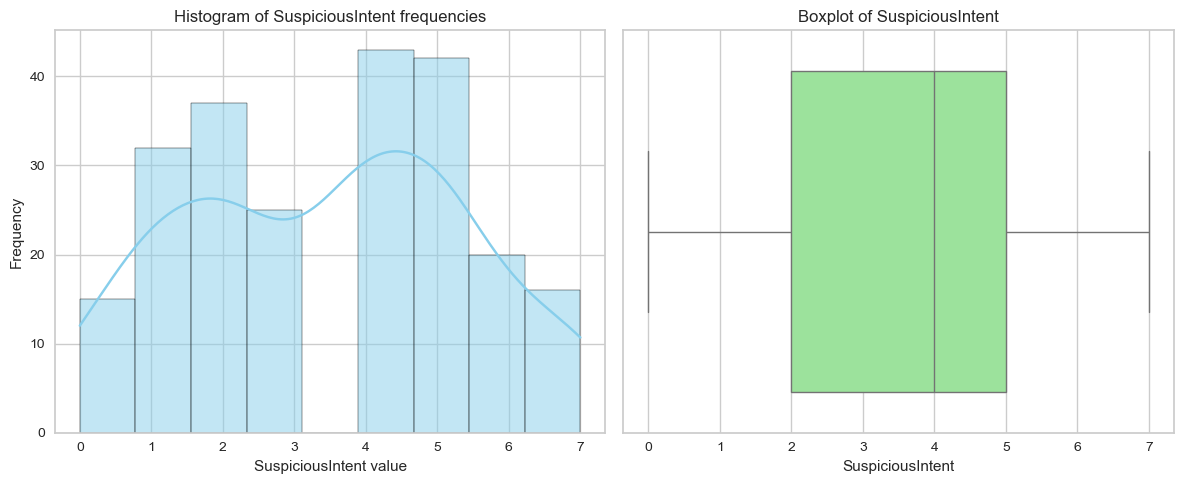

Descriptive statistics for Wariness:
 count    230.000000
mean       3.952174
std        1.846126
min        0.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        7.000000
Name: Wariness, dtype: float64


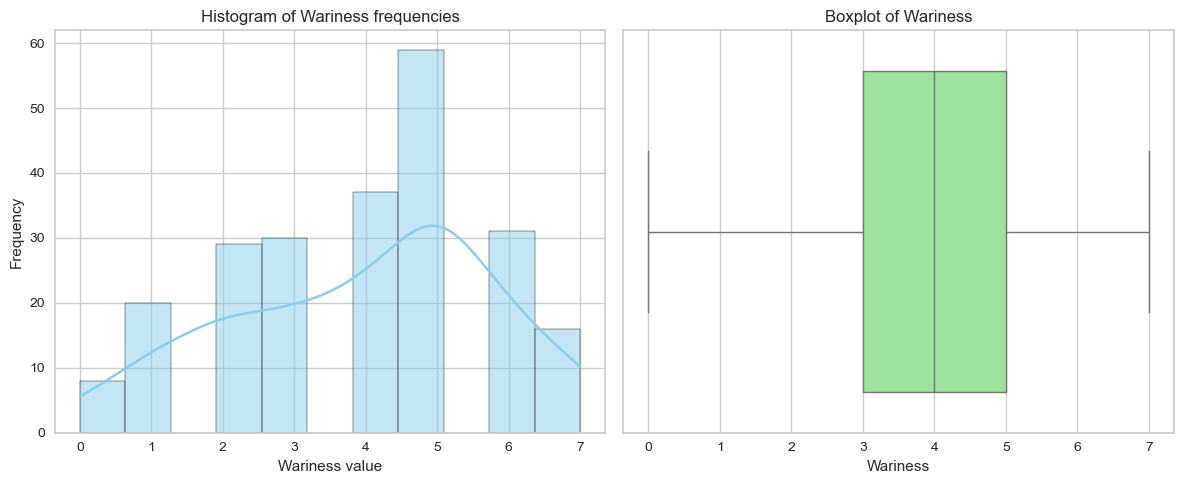

Descriptive statistics for Harmful:
 count    230.000000
mean       2.600000
std        1.898287
min        0.000000
25%        1.000000
50%        2.000000
75%        4.000000
max        7.000000
Name: Harmful, dtype: float64


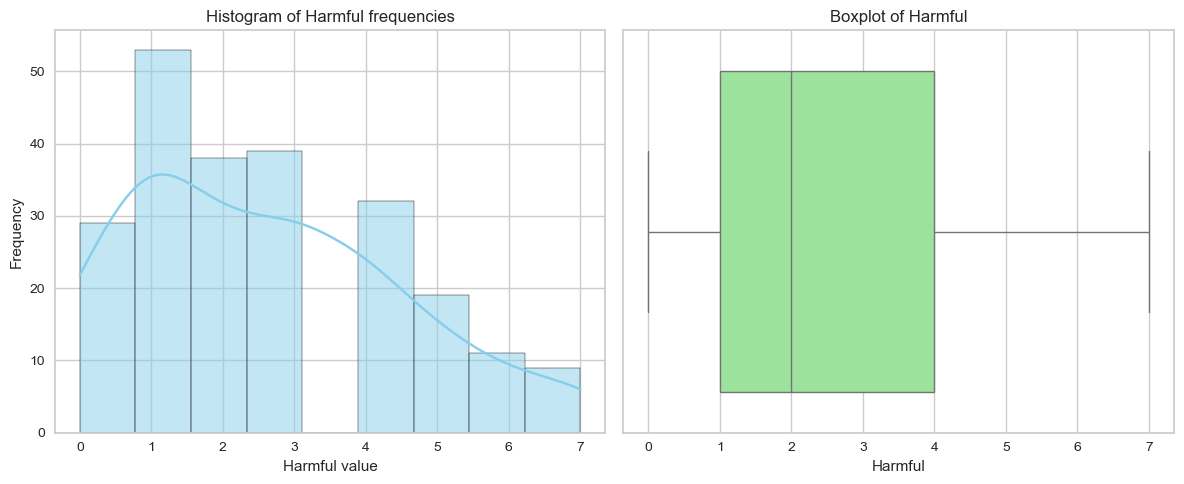

Descriptive statistics for Confident:
 count    230.000000
mean       3.908696
std        1.898152
min        0.000000
25%        2.000000
50%        4.000000
75%        5.000000
max        7.000000
Name: Confident, dtype: float64


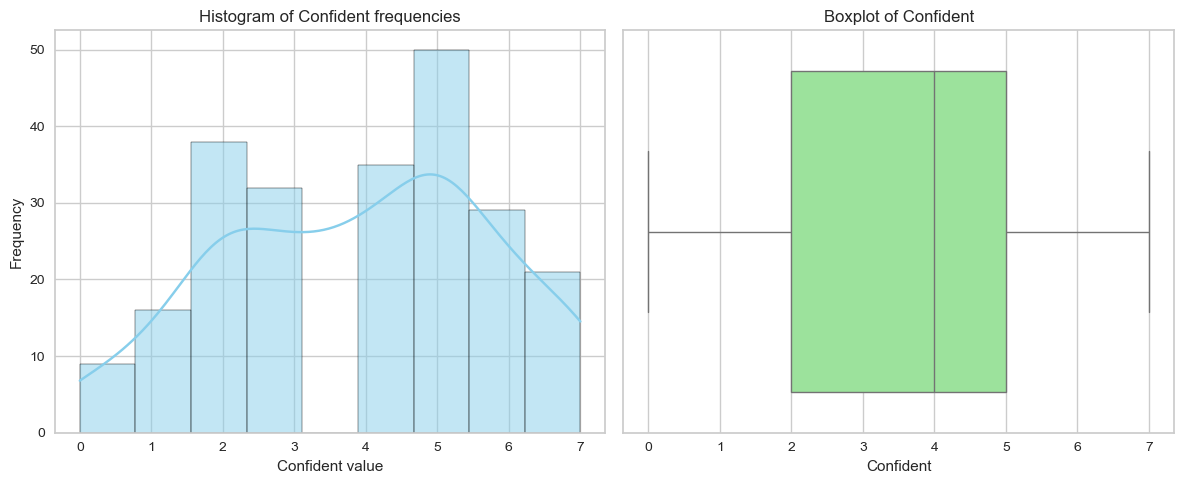

Descriptive statistics for Secure:
 count    230.000000
mean       3.808696
std        1.842704
min        0.000000
25%        2.000000
50%        4.000000
75%        5.000000
max        7.000000
Name: Secure, dtype: float64


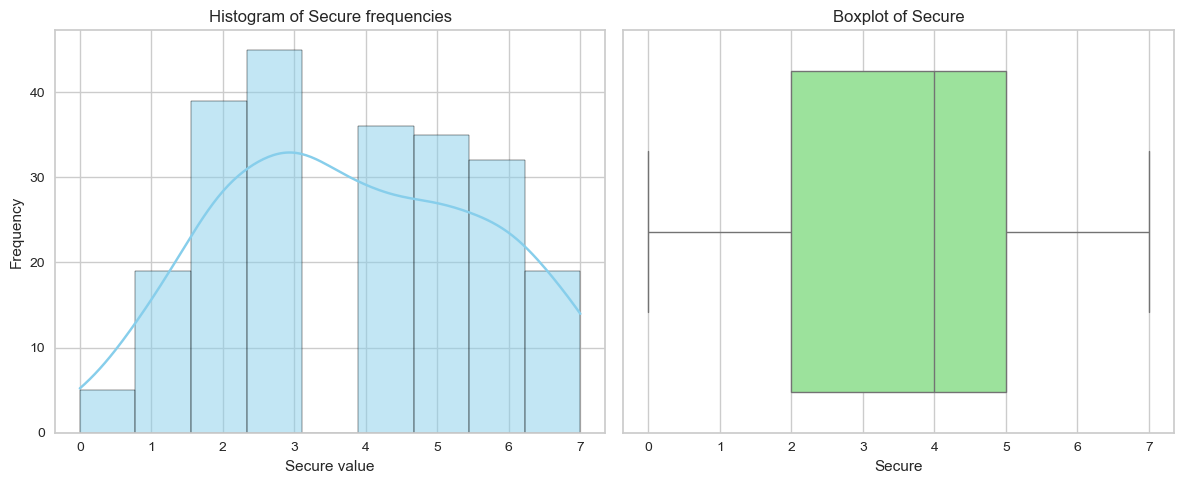

Descriptive statistics for Integrity:
 count    230.000000
mean       3.917391
std        1.937259
min        0.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        7.000000
Name: Integrity, dtype: float64


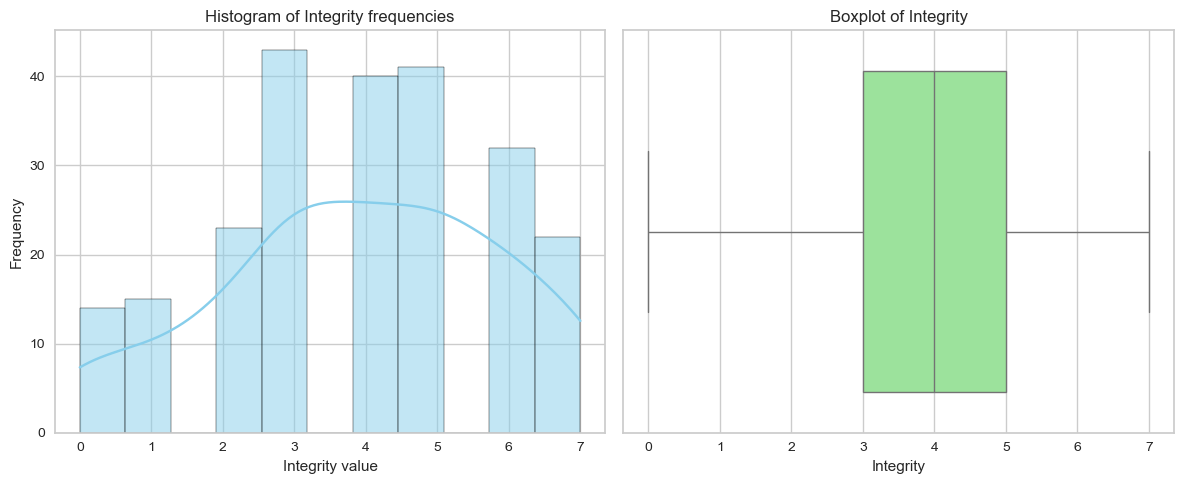

Descriptive statistics for Dependable:
 count    230.000000
mean       4.234783
std        1.879935
min        0.000000
25%        3.000000
50%        4.000000
75%        6.000000
max        7.000000
Name: Dependable, dtype: float64


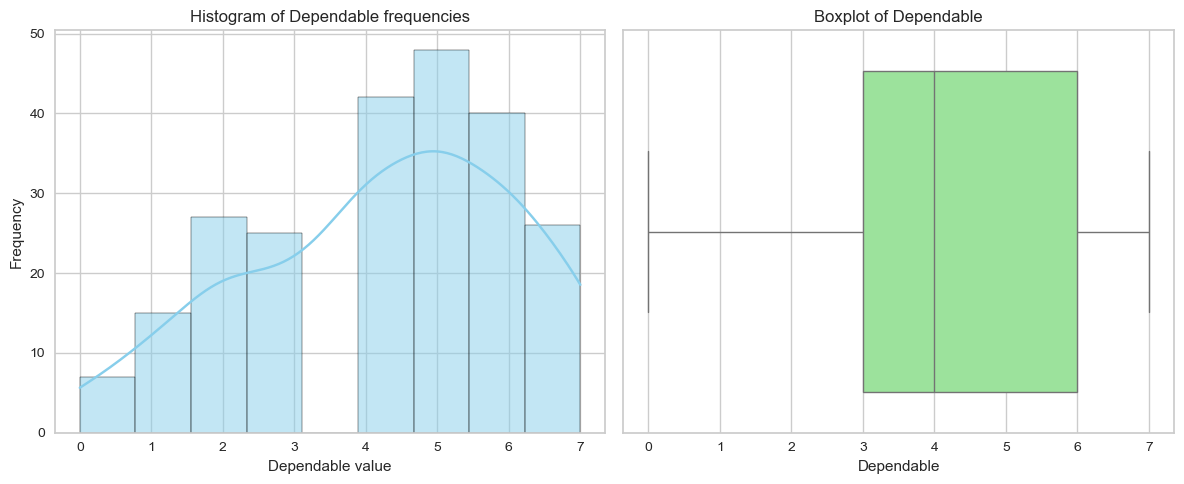

Descriptive statistics for Familiarity:
 count    230.000000
mean       3.217391
std        2.027249
min        0.000000
25%        2.000000
50%        3.000000
75%        5.000000
max        7.000000
Name: Familiarity, dtype: float64


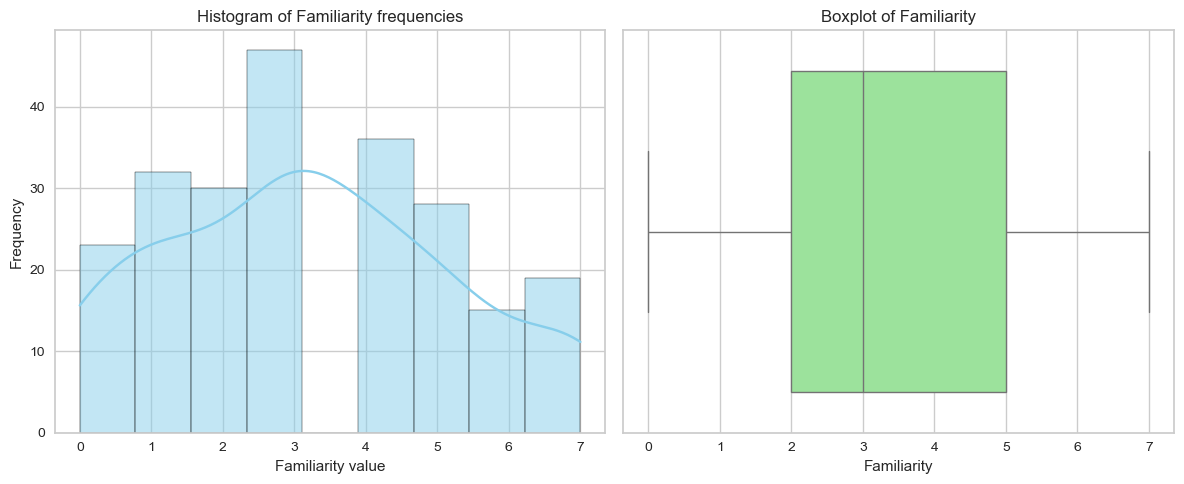

Descriptive statistics for Trust:
 count    230.000000
mean       3.956522
std        1.962047
min        0.000000
25%        3.000000
50%        4.000000
75%        6.000000
max        7.000000
Name: Trust, dtype: float64


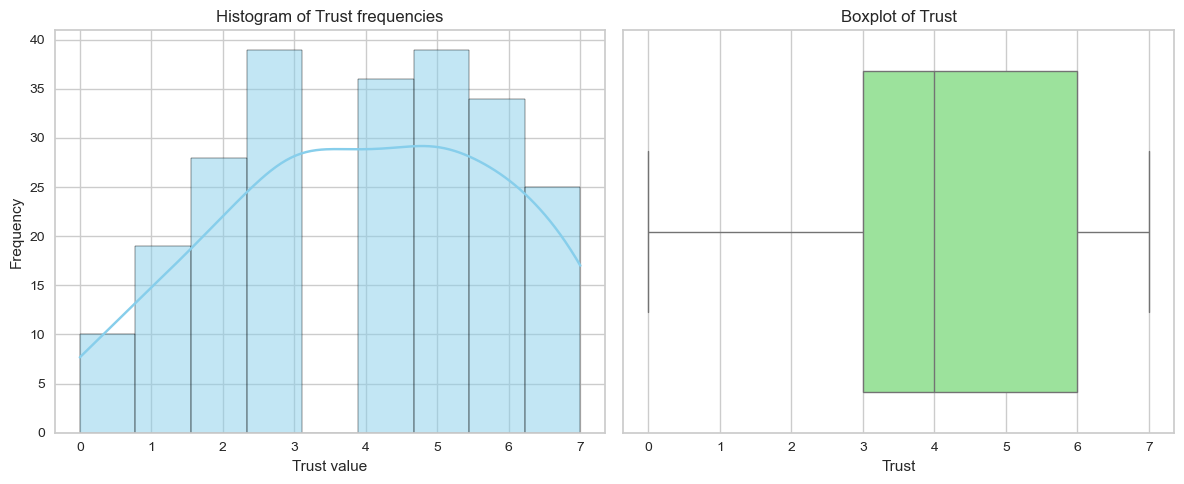

Descriptive statistics for Rating:
 count    227.000000
mean       4.383260
std        0.861303
min        1.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: Rating, dtype: float64


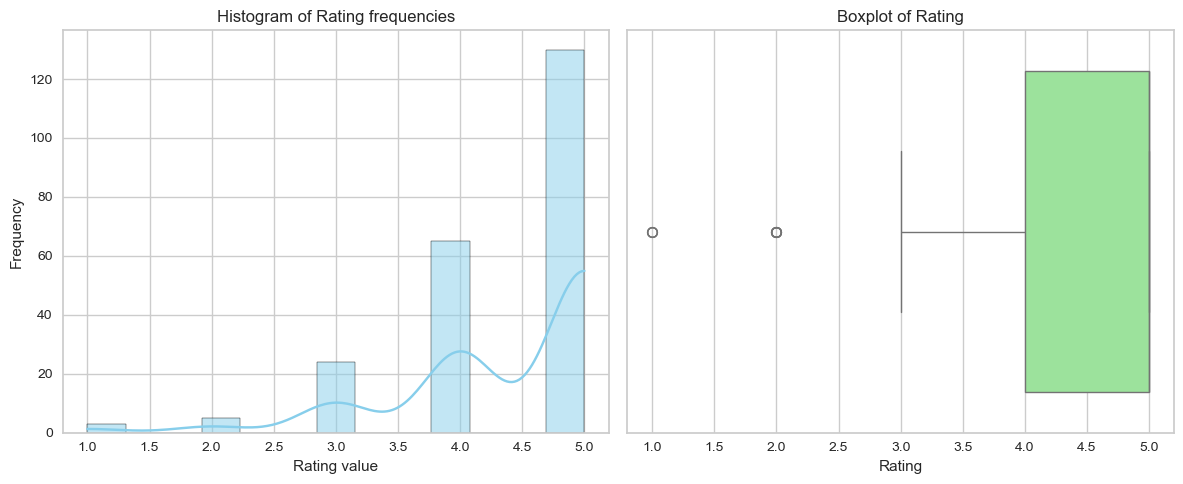

Descriptive statistics for Negative:
 count    230.000000
mean       3.317391
std        1.474308
min        0.000000
25%        2.200000
50%        3.400000
75%        4.400000
max        6.400000
Name: Negative, dtype: float64


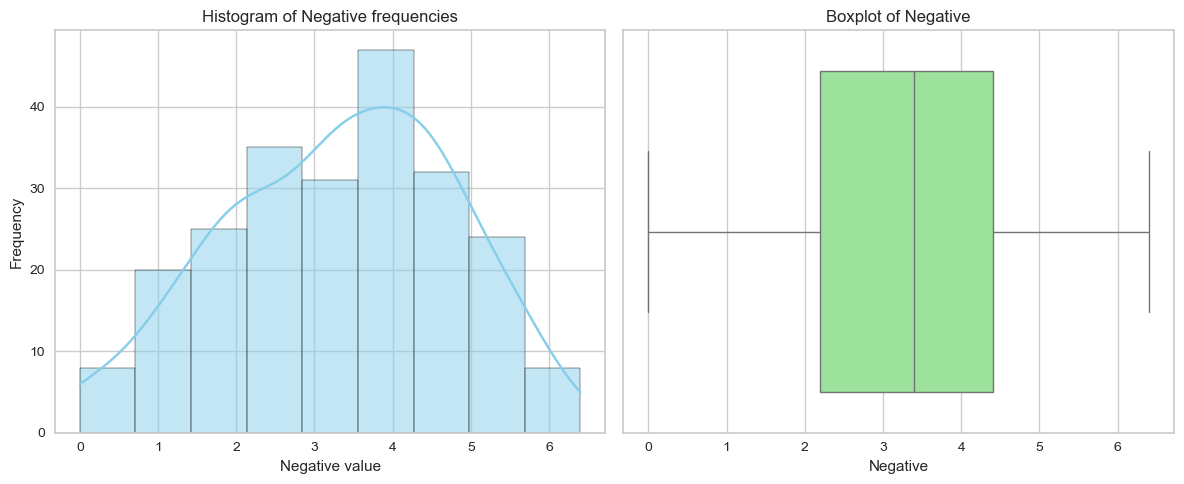

Descriptive statistics for Positive:
 count    230.000000
mean       3.967391
std        1.571450
min        0.000000
25%        2.750000
50%        4.000000
75%        5.000000
max        7.000000
Name: Positive, dtype: float64


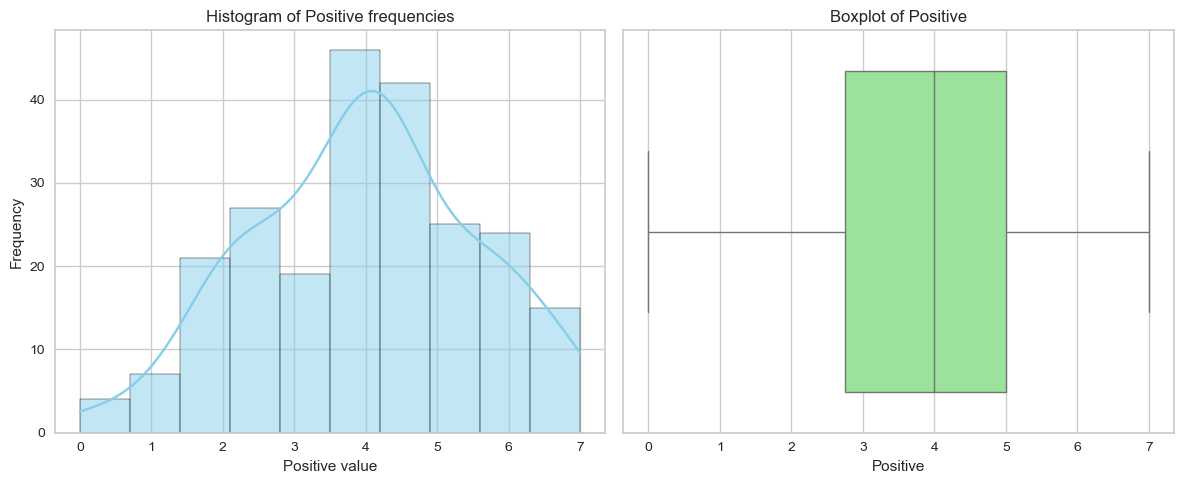

Descriptive statistics for SentimentLevelQuadrant:
 count    230.000000
mean       2.530435
std        1.169643
min        1.000000
25%        2.000000
50%        2.000000
75%        4.000000
max        4.000000
Name: SentimentLevelQuadrant, dtype: float64


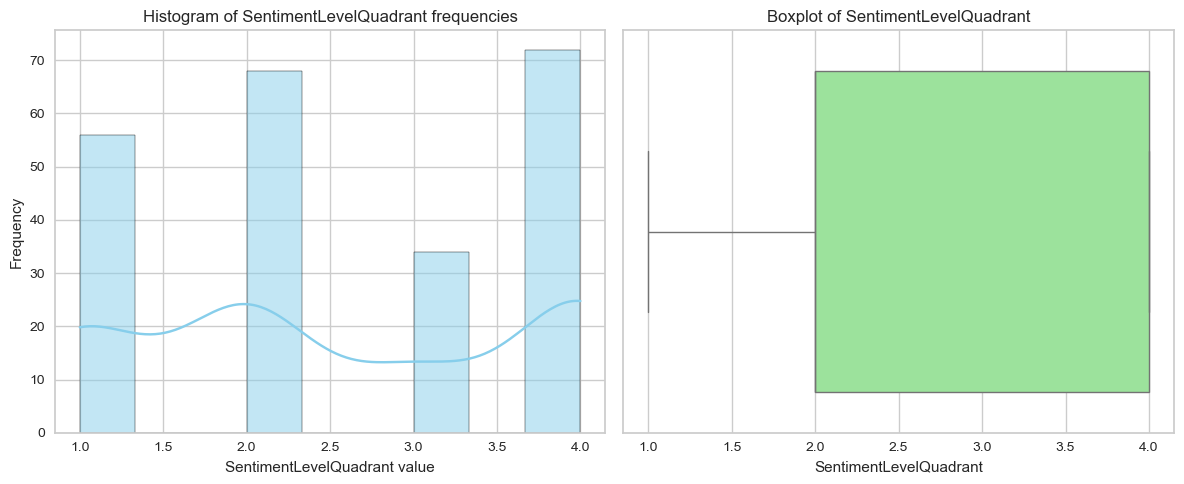

Descriptive statistics for NumPT:
 count    230.000000
mean       2.330435
std        0.756015
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        3.000000
Name: NumPT, dtype: float64


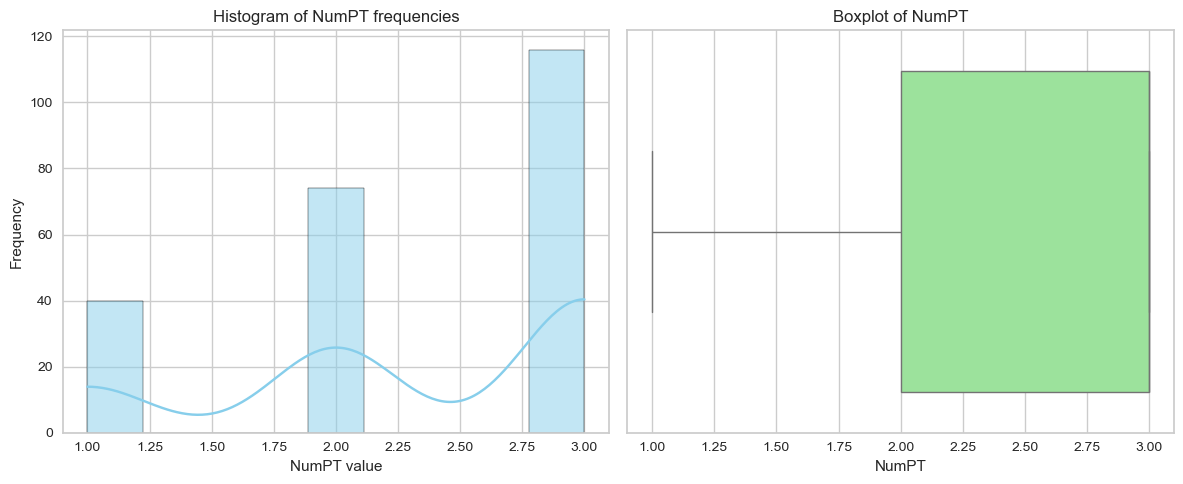

Descriptive statistics for NumExp:
 count    230.000000
mean       0.213043
std        0.410351
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: NumExp, dtype: float64


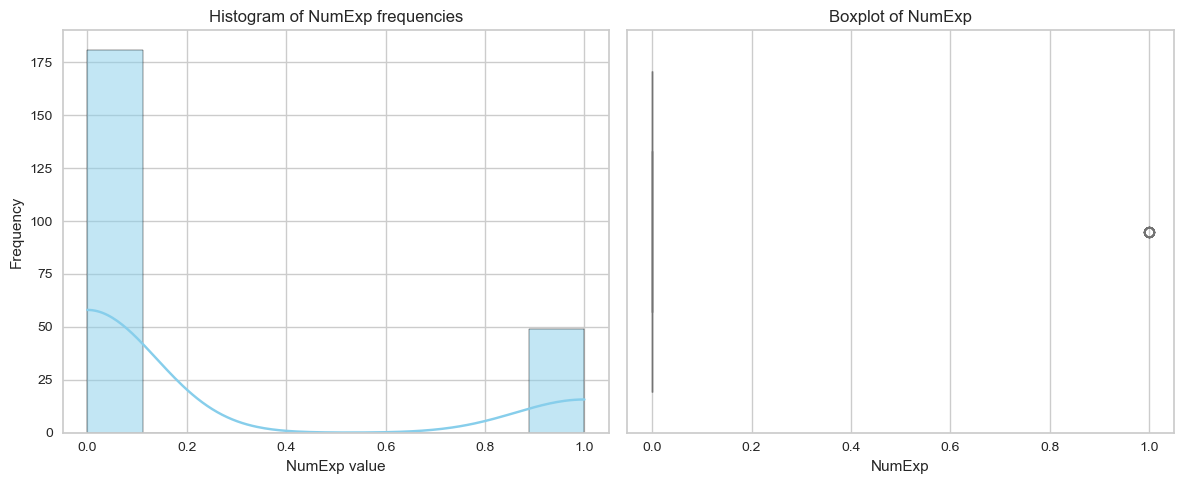

Descriptive statistics for NumPref:
 count    230.000000
mean       0.395652
std        0.490057
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: NumPref, dtype: float64


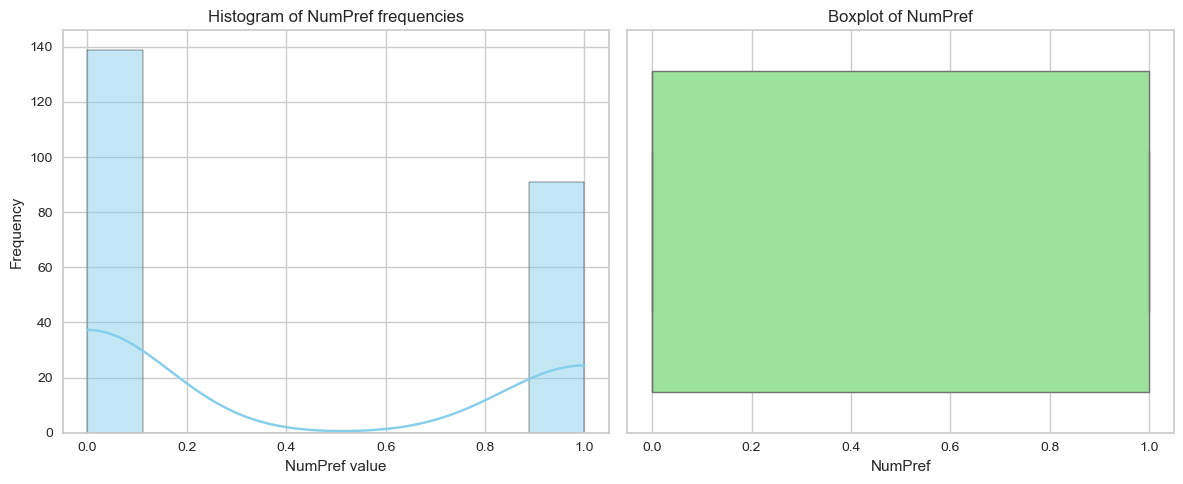

In [10]:
# Generate the descriptive statistics for all numerical columns.
for i in numeric_cols:
    describe_and_visualize(red, i)
    

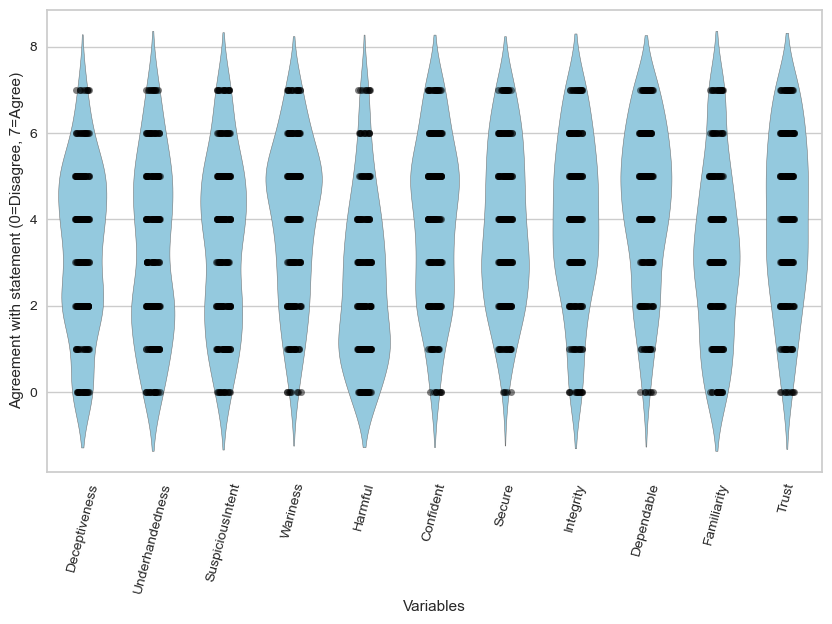

In [11]:
# Genreate the sina graph for all main question columns.
plot_sina(red, main_questions)

In [12]:
# a dataframe is generated with only numeric columns
numdf = red[numeric_cols]
# A dataframe is generated with the curated columns for an MLR.
simpledf = red[simple_columns]
# A dataframe is generated with the curated columns for an MLR for the second grouping.
simpledf2 = red[simple2]
# A dataframe is generated specifically for PCA
pcadf = red[for_pca]
simple_columns.remove('NumPT')
simple2.remove('AltPT')
numdf =numdf.drop(['Rating'], axis=1)

In [13]:
# Preparing to undergo PCA for Profession Type
pcadf['ProfessionType'] = red['ProfessionType']
# A dataframe with the main questions from the questionnaire
main_df = pcadf.drop(['Age'], axis=1)
main_df_PCA = main_df.drop(['NumPT', 'ProfessionType'], axis=1)

C:\Users\Jaime\AppData\Local\Temp\ipykernel_6832\2695559633.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pcadf['ProfessionType'] = red['ProfessionType']


In [14]:
# PCA for profession type is performed
perform_pca(main_df_PCA, 2)
main_df[['PC1', 'PC2']] = main_df_PCA[['PC1', 'PC2']]

[0.41023758 0.2109744 ]
Explained Variance for PC1: 0.4102
Explained Variance for PC2: 0.2110


['Scientific (n=116)', 'Social (n=74)', 'Artistic (n=40)']


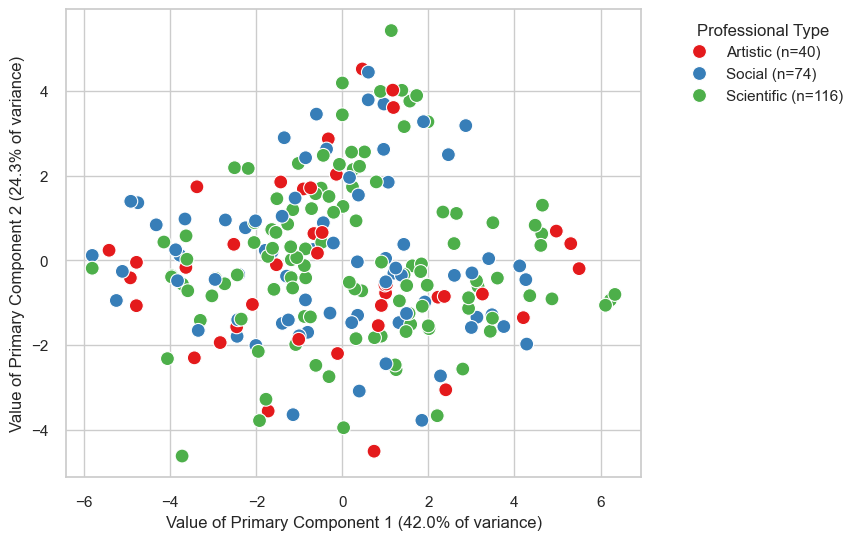

In [15]:
# A scatterplot plotting the data using the primary components is generated and saved.
scatter_for_PCA(main_df, 'PC1', 'PC2', 'ProfessionType', 'Professional Type', 'PCAProfessionalType', 'Value of Primary Component 1 (42.0% of variance)', 'Value of Primary Component 2 (24.3% of variance)')



In [16]:
# simpledf undergoes multinomial logistic regression to show relationships between variables
multinomial_logistic_regression(simpledf, 'NumPT', simple_columns)


Optimization terminated successfully.
         Current function value: 0.934547
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                  NumPT   No. Observations:                  230
Model:                        MNLogit   Df Residuals:                      204
Method:                           MLE   Df Model:                           24
Date:                Mon, 02 Sep 2024   Pseudo R-squ.:                 0.07862
Time:                        23:00:50   Log-Likelihood:                -214.95
converged:                       True   LL-Null:                       -233.29
Covariance Type:            nonrobust   LLR p-value:                   0.04708
               NumPT=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -3.0141      1.746     -1.726      0.084      -6.436      

In [17]:
# Auxiliary dataframe simple2 is generated to undergo MLR with different values for Professional Type in order to obtain all comparisons
simple2 = simpledf.copy()
simple2['NumPT'] = red['AltPT']
# simple2 undergoes MLR
multinomial_logistic_regression(simple2, 'NumPT', simple_columns)

Optimization terminated successfully.
         Current function value: 0.934547
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                  NumPT   No. Observations:                  230
Model:                        MNLogit   Df Residuals:                      204
Method:                           MLE   Df Model:                           24
Date:                Mon, 02 Sep 2024   Pseudo R-squ.:                 0.07862
Time:                        23:00:50   Log-Likelihood:                -214.95
converged:                       True   LL-Null:                       -233.29
Covariance Type:            nonrobust   LLR p-value:                   0.04708
               NumPT=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  2.6746      1.646      1.625      0.104      -0.552      

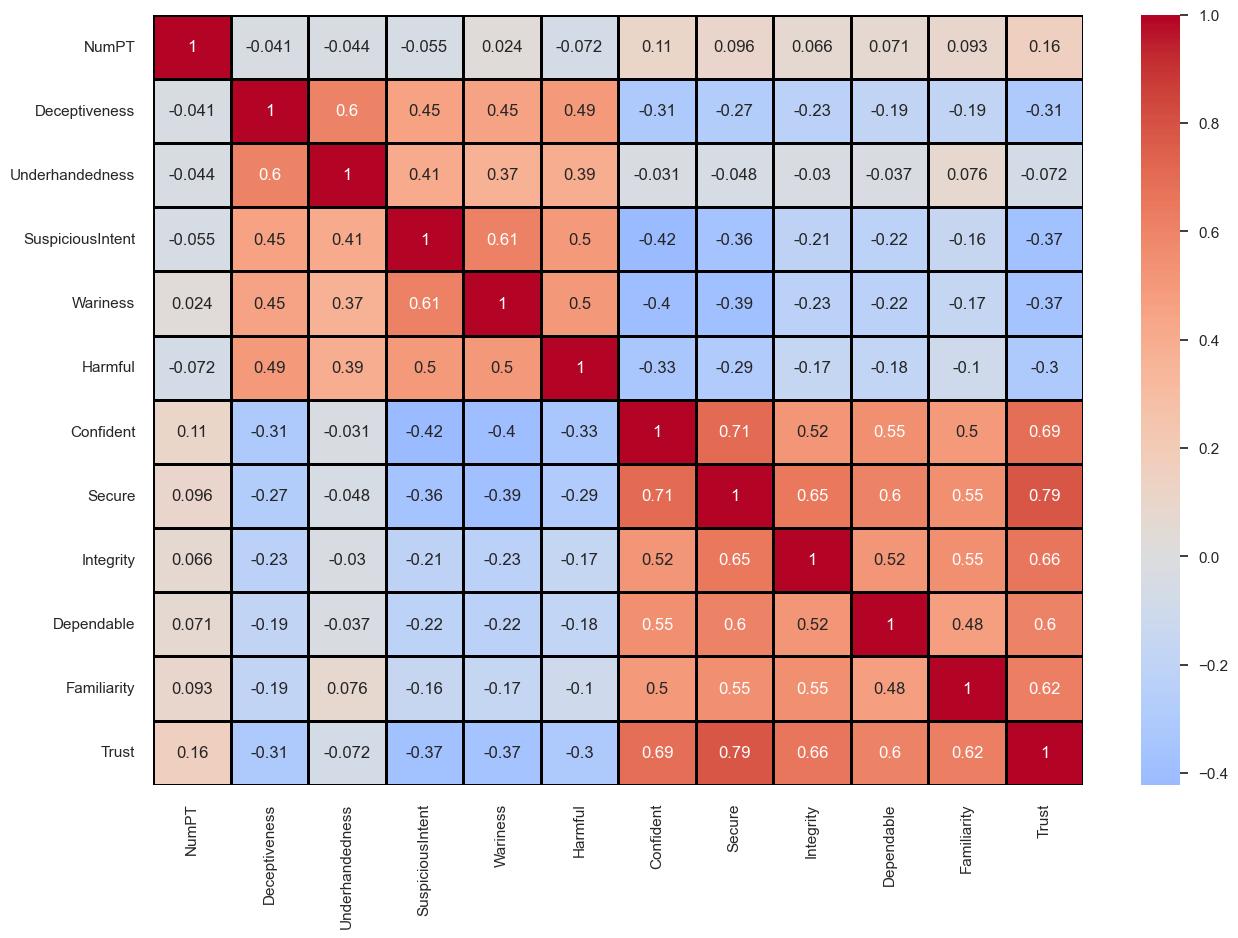

In [18]:
correlation_matrix(red, 'redMQs', 'NumPT', main_questions)

In [19]:
art = red[red['ProfessionType'] == 'Artistic'].copy()


sci = red[red['ProfessionType'] == 'Scientific'].copy()


soc = red[red['ProfessionType'] == 'Social'].copy()

In [20]:
i_statements = ['Age', 'Secure', 'Positive', 'Trust', 'NumPref']

In [21]:
plot_radar_chart_normalized(art, sci, soc, i_statements, 'ProfessionalTypes', 'Artistic', 'Scientific', 'Social')

In [22]:
art['Age'].mean()

23.25

In [23]:
sci['NumPref'].mean()

0.3706896551724138

In [24]:
soc['Age'].mean()

28.986486486486488

In [25]:
for_clustering = main_df.drop(['PC1', 'PC2'], axis=1)

C:\Users\Jaime\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Jaime\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Jaime\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Jaime\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

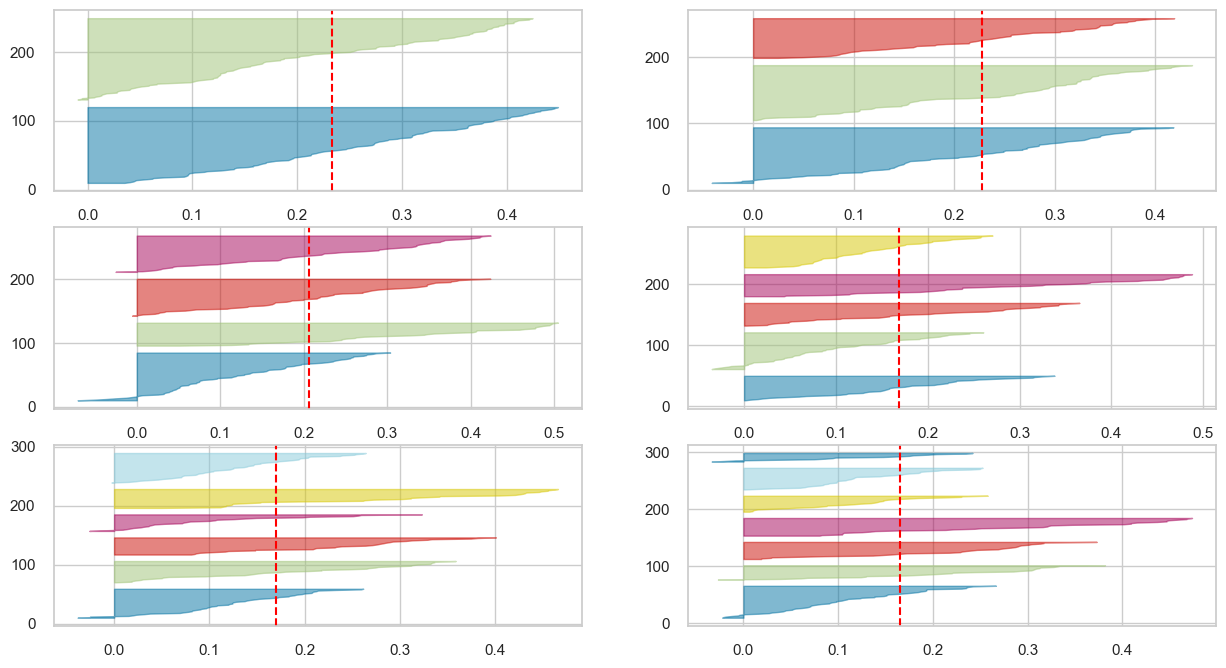

In [26]:

# Extract X (features), which is everything else except NumPT
X = for_clustering.drop(['ProfessionType'], axis=1)

fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)  

C:\Users\Jaime\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


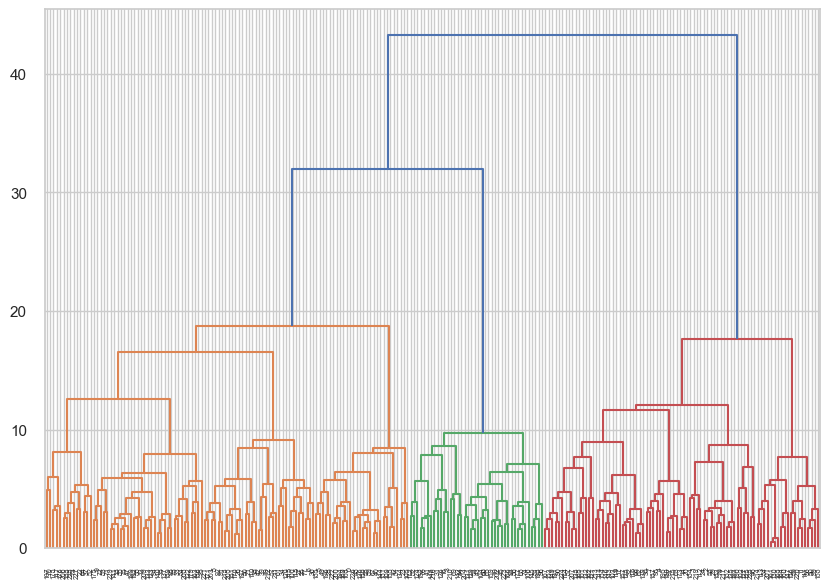

0      0
1      1
2      1
3      2
4      1
      ..
227    1
228    0
229    0
230    0
231    0
Name: Cluster, Length: 230, dtype: int64

In [27]:
# The instability of trees makes it difficult to generate the exact grouping every time
perform_hierarchical_clustering(X, 3)

In [28]:
target = X['Cluster']
variables = X.drop(['Cluster'], axis=1)
var_list = list(variables.columns)
var_list

['Deceptiveness',
 'Underhandedness',
 'SuspiciousIntent',
 'Wariness',
 'Harmful',
 'Confident',
 'Secure',
 'Integrity',
 'Dependable',
 'Familiarity',
 'Trust',
 'Negative',
 'Positive',
 'SentimentLevelQuadrant',
 'NumPT',
 'NumExp',
 'NumPref']

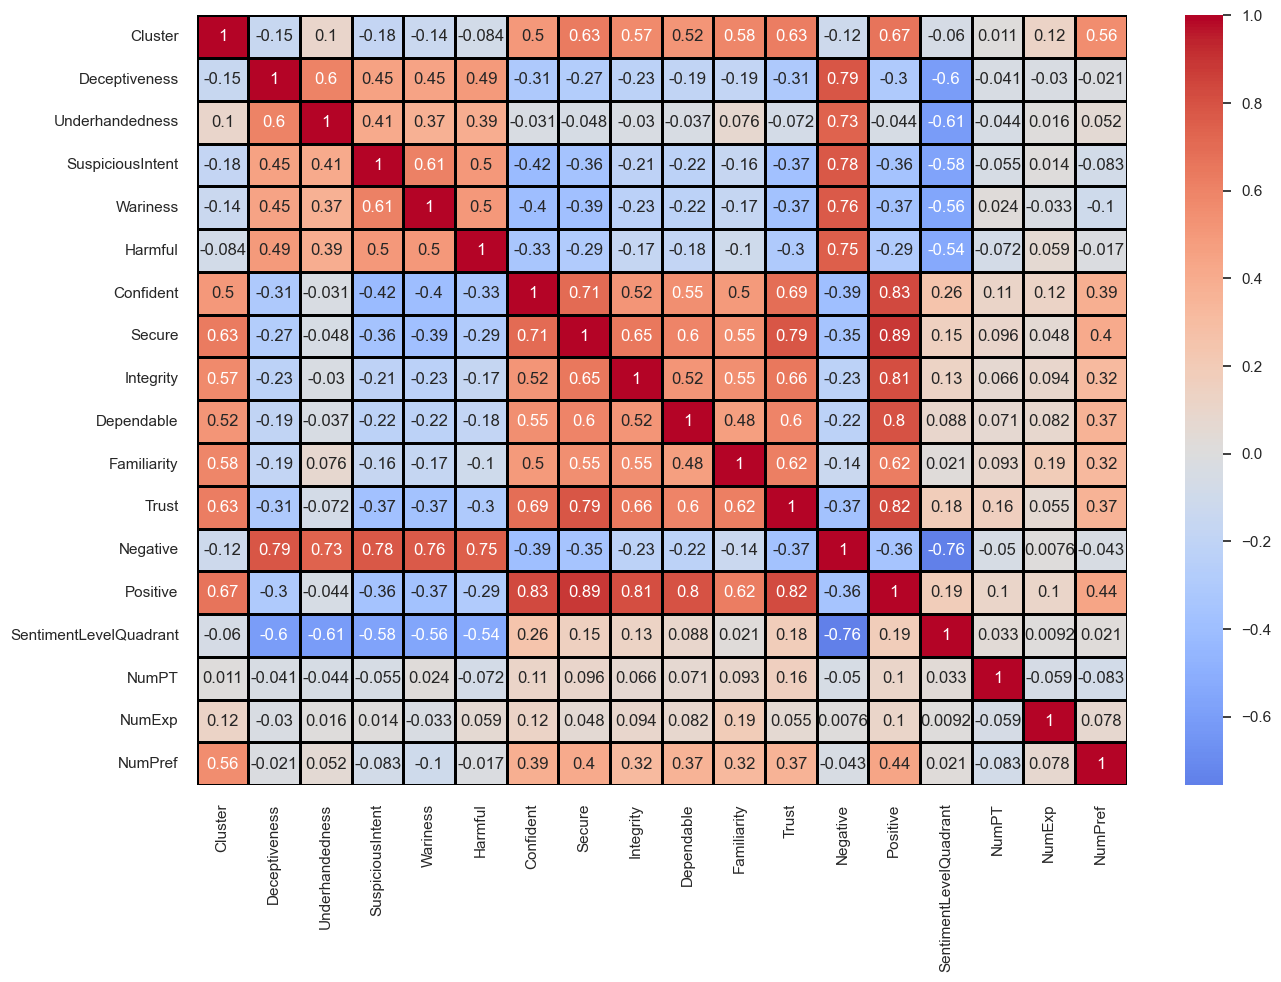

In [29]:
correlation_matrix(X, 'NeoClustering', 'Cluster', var_list)

In [30]:
explore = variables.drop(['Negative', 'Positive', 'SentimentLevelQuadrant'], axis=1)
calculate_vif(explore)


,Feature,VIF
0,Deceptiveness,2.035387
1,Underhandedness,1.872739
2,SuspiciousIntent,1.950578
3,Wariness,1.904346
4,Harmful,1.655665
5,Confident,2.614899
6,Secure,3.424082
7,Integrity,2.045823
8,Dependable,1.808144
9,Familiarity,1.906757


In [31]:
scaler = StandardScaler()
explore_scaled = scaler.fit_transform(explore)
explore_scaled

array([[ 0.34908133, -0.12041368,  1.79224795, ..., -1.7636375 ,
        -0.5203059 ,  1.2359096 ],
       [-1.22520701,  1.36325488, -1.24247864, ..., -0.43802761,
         1.92194629, -0.80912067],
       [-0.70044423, -0.61496987, -1.24247864, ...,  0.88758227,
        -0.5203059 , -0.80912067],
       ...,
       [-0.70044423, -0.61496987,  0.78067242, ..., -1.7636375 ,
         1.92194629, -0.80912067],
       [ 0.87384411, -0.61496987,  0.78067242, ...,  0.88758227,
         1.92194629, -0.80912067],
       [ 0.34908133,  0.37414251,  0.27488466, ...,  0.88758227,
        -0.5203059 , -0.80912067]])

In [32]:
cols = explore.columns

In [33]:
scaled_df=pd.DataFrame(explore_scaled, columns=cols)
scaled_df['Cluster'] = X['Cluster'].astype(int)
scaled_df['AltClustering'] = scaled_df['Cluster'].map({0:1, 1:2, 2:0})
scaled_df.head()

,Deceptiveness,Underhandedness,SuspiciousIntent,Wariness,Harmful,Confident,Secure,Integrity,Dependable,Familiarity,Trust,NumPT,NumExp,NumPref,Cluster,AltClustering
0,0.349081,-0.120414,1.792248,0.025963,1.794995,-1.535725,-2.071414,-2.026542,-1.191348,-1.590534,-2.020925,-1.763637,-0.520306,1.235910,0.0,1.0
1,-1.225207,1.363255,-1.242479,-1.602606,-0.316764,0.576184,0.104044,1.077373,-1.724441,-1.096179,0.532991,-0.438028,1.921946,-0.809121,1.0,2.0
2,-0.700444,-0.614970,-1.242479,-0.516893,-0.844703,0.576184,-0.439821,-0.474584,0.941026,-0.107468,1.554558,0.887582,-0.520306,-0.809121,1.0,2.0
3,0.873844,1.857811,-0.736691,1.111675,-0.316764,1.632138,1.191772,1.077373,0.407932,1.375597,1.043775,0.887582,1.921946,1.235910,2.0,0.0
4,-0.700444,-0.614970,-0.736691,-0.516893,-0.316764,0.576184,0.647908,0.042735,-1.191348,-0.601824,-0.488575,0.887582,1.921946,-0.809121,1.0,2.0


In [34]:
multinomial_logistic_regression(scaled_df, 'Cluster', cols)


Optimization terminated successfully.
         Current function value: 0.590098
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                Cluster   No. Observations:                  228
Model:                        MNLogit   Df Residuals:                      198
Method:                           MLE   Df Model:                           28
Date:                Mon, 02 Sep 2024   Pseudo R-squ.:                  0.4266
Time:                        23:00:59   Log-Likelihood:                -134.54
converged:                       True   LL-Null:                       -234.66
Covariance Type:            nonrobust   LLR p-value:                 6.187e-28
       Cluster=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.4708      0.220     -2.144      0.032      -0.901      -0.040
Deceptivene

In [35]:
multinomial_logistic_regression(scaled_df, 'AltClustering', cols)

Optimization terminated successfully.
         Current function value: 0.590098
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:          AltClustering   No. Observations:                  228
Model:                        MNLogit   Df Residuals:                      198
Method:                           MLE   Df Model:                           28
Date:                Mon, 02 Sep 2024   Pseudo R-squ.:                  0.4266
Time:                        23:00:59   Log-Likelihood:                -134.54
converged:                       True   LL-Null:                       -234.66
Covariance Type:            nonrobust   LLR p-value:                 6.187e-28
 AltClustering=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.7869      0.374      4.783      0.000       1.055       2.519
Deceptivene

In [36]:
X['PC1'] = main_df['PC1']
X['PC2'] = main_df['PC2']
X.head()

,Deceptiveness,Underhandedness,SuspiciousIntent,Wariness,Harmful,Confident,Secure,Integrity,Dependable,Familiarity,Trust,Negative,Positive,SentimentLevelQuadrant,NumPT,NumExp,NumPref,Cluster,PC1,PC2
0,4.0,3.0,7.0,4.0,6.0,1.0,0.0,0.0,2.0,0.0,0.0,4.8,0.75,2,1,0,1,0,-4.788066,-1.065987
1,1.0,6.0,1.0,1.0,2.0,5.0,4.0,6.0,1.0,1.0,5.0,2.2,4.00,4,2,1,0,1,1.315085,-1.464668
2,2.0,2.0,1.0,3.0,1.0,5.0,3.0,3.0,6.0,3.0,7.0,1.8,4.25,4,3,0,0,1,2.012298,-1.607875
3,5.0,7.0,2.0,6.0,2.0,7.0,6.0,6.0,5.0,6.0,6.0,4.4,6.00,1,3,1,1,2,1.566968,3.756284
4,2.0,2.0,2.0,3.0,2.0,5.0,5.0,4.0,2.0,2.0,3.0,2.2,4.00,4,3,1,0,1,0.902412,-1.783599


In [37]:
X['Age'] = red['Age']

In [38]:
x0 = X[X['Cluster'] == 0].copy()


x1 = X[X['Cluster'] == 1].copy()


x2 = X[X['Cluster'] == 2].copy()

important_statements = ['Deceptiveness', 'Underhandedness', 'Wariness', 'Harmful', 'Secure']

profiling_statements = ['Age', 'NumExp', 'NumPref']


In [39]:
plot_radar_chart(x0, x1, x2, important_statements, 'NewClusters', 'Trustful', 'Undecided', 'Distrustful')

In [40]:
cluster_map = {
    0: 'Trustful',
    1: 'Undecided',
    2: 'Distrustful'
}
X['NeoClass'] = X['Cluster'].map(cluster_map)
X.head()

,Deceptiveness,Underhandedness,SuspiciousIntent,Wariness,Harmful,Confident,Secure,Integrity,Dependable,Familiarity,...,Positive,SentimentLevelQuadrant,NumPT,NumExp,NumPref,Cluster,PC1,PC2,Age,NeoClass
0,4.0,3.0,7.0,4.0,6.0,1.0,0.0,0.0,2.0,0.0,...,0.75,2,1,0,1,0,-4.788066,-1.065987,24.0,Trustful
1,1.0,6.0,1.0,1.0,2.0,5.0,4.0,6.0,1.0,1.0,...,4.00,4,2,1,0,1,1.315085,-1.464668,26.0,Undecided
2,2.0,2.0,1.0,3.0,1.0,5.0,3.0,3.0,6.0,3.0,...,4.25,4,3,0,0,1,2.012298,-1.607875,26.0,Undecided
3,5.0,7.0,2.0,6.0,2.0,7.0,6.0,6.0,5.0,6.0,...,6.00,1,3,1,1,2,1.566968,3.756284,61.0,Distrustful
4,2.0,2.0,2.0,3.0,2.0,5.0,5.0,4.0,2.0,2.0,...,4.00,4,3,1,0,1,0.902412,-1.783599,24.0,Undecided


['Trustful (n=108)', 'Undecided (n=82)', 'Distrustful (n=40)']


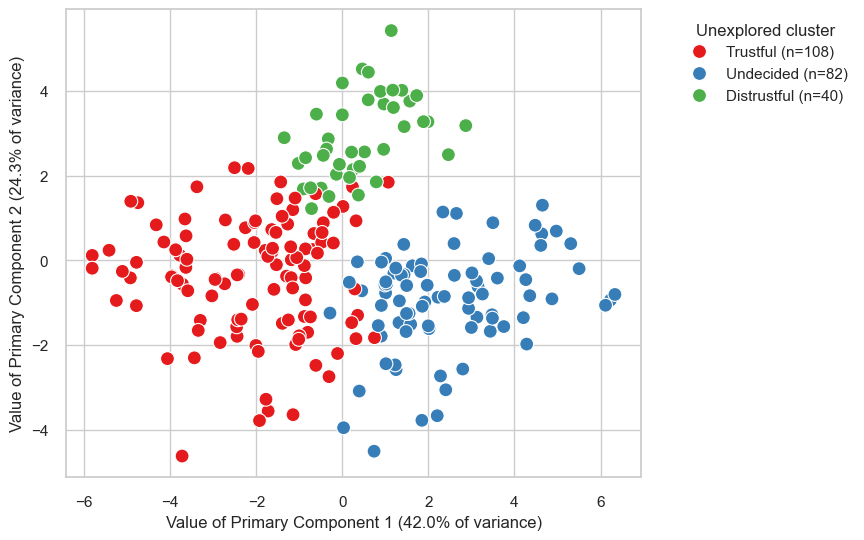

In [41]:
scatter_for_PCA(X, 'PC1', 'PC2', 'NeoClass', 'Unexplored cluster', 'PCANeoClusters', 'Value of Primary Component 1 (42.0% of variance)', 'Value of Primary Component 2 (24.3% of variance)')

